# Notebook description

The purpose of this notebook is to determine the optimum values of the Random Forest Classifier (`scikit-learn`) model parameters. The parameters to optimize are
* `n_estimators`: The number of trees in the random forest. Larger numbers decrease variance with diminishing returns with very large numbers of trees. In some cases larger numbers can increase model bias. 
* `max_features`: The number of features (input variables) to consider at each internal node of the trees in the random forest. Higher values of `max_features` tends to increase how much the model "learns" from the training data. Including too many features can easily lead to overfitting.

To optimize these parameters, we split the data into a training and a test set. We train the data on the training set, choosing the values of `n_estimators` and `max_features` that maximizes the ROC AUC score on the test set.

Since the data is sequenced in time, we split the data into 'old' (training) and 'new' (test) categories. This simulates the real world situation of predicting new outcomes that may be correlated in time with the training data.

# Preliminary

In [176]:
# Imports
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = (10, 6)
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
import pandas as pd
from dateutil.parser import parse
from datetime import timedelta
from pprint import pprint as pp
import math

RANDOM_STATE = 7

In [177]:
# Import the ebay data set
data = pd.read_csv('../Data/ebay_data_rf_endtime.csv', index_col=False)
print("Shape:", data.shape)
pp(data.columns)

Shape: (44840, 22)
Index(['productId_type', 'productId_value', 'conditionDisplayName',
       'conditionId', 'endTime', 'country', 'listingType', 'buyItNowAvailable',
       'bestOfferEnabled', 'paymentMethod', 'expeditedShipping',
       'shippingType', 'isShippingFree', 'returnsAccepted',
       'feedbackRatingStar', 'feedbackScore', 'positiveFeedbackPercent',
       'topRatedSeller', 'value', 'sellingState', 'endHour', 'endWeekday'],
      dtype='object')


# Preprocessing

In [178]:
# Separate the target and inputs
y = data.sellingState
T = data.endTime
X = data.drop(['sellingState','endTime'], axis=1)
T_dt = [parse(x) for x in T]

In [179]:
# Ebay gives you access to listings from the past 90 days
DeltaT = (T_dt[0]-T_dt[-1])
print("Total days of data:", DeltaT.total_seconds()/86400)

Total days of data: 89.98267361111111


In [180]:
# Split the data into train and test. 
frac = 0.15
ind = math.ceil(42028 * frac)

test_ind = range(0,ind)
train_ind = range(ind,len(y))

X_train = X.iloc[train_ind]
X_test = X.iloc[test_ind]
y_train = y[list(train_ind)]
y_test = y[list(test_ind)]

In [181]:
print(X_train.shape)
print(X_test.shape)
print(len(y_train))
print(len(y_test))

(38535, 20)
(6305, 20)
38535
6305


# Optimizing the RF model parameters 

## `n_estimators`

In [182]:
# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for paralellised ensembles but is necessary for tracking the OOB
# error trajectory during training.

ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True,
                               max_features="sqrt",
                               oob_score=False,
                               n_jobs = 3,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=7",
        RandomForestClassifier(warm_start=True,
                               max_features=7,
                               n_jobs = 3,
                               oob_score=False,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='None'",
        RandomForestClassifier(warm_start=True,
                               max_features=None,
                               n_jobs = 3,
                               oob_score=False,
                               random_state=RANDOM_STATE))
]

In [183]:
# Map a classifier name to a list of (<n_estimators>, <auc_score>) pairs.
auc_scores = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 80
max_estimators = 320

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1,5):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the ROC AUC error for each `n_estimators=i` setting.
        y_pred = clf.predict_proba(X_test)[:,1]
        auc = roc_auc_score(y_test, y_pred)
        auc_scores[label].append((i, auc))

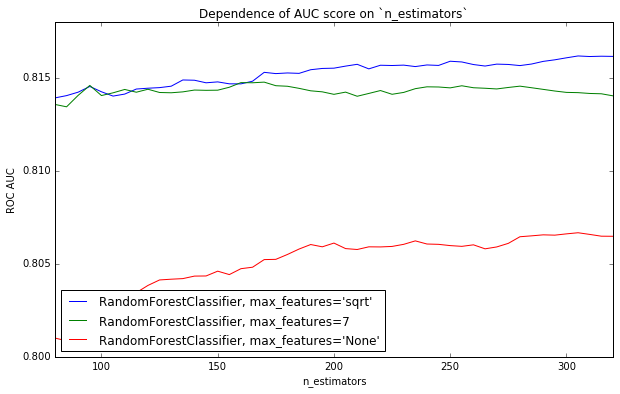

In [184]:
for label, x in auc_scores.items():
    xs, ys = zip(*x)
    plt.plot(xs, ys, label=label)

plt.title("Dependence of AUC score on `n_estimators`")
plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("ROC AUC")
plt.legend(loc="lower left")

plt.show()

In [185]:
# Select the model with the highest score

# Get the curve with the best roc auc score
g = lambda x: x[1]
f = lambda y: max( y[1], key = g)
best_model = max(list(auc_scores.items()), key = f)

print("Best model:", best_model[0])

# Get the best score for the model
best_score = max(best_model[1], key = g)

print("Best (<n_estimators>, <roc auc>):", best_score)

Best model: RandomForestClassifier, max_features='sqrt'
Best (<n_estimators>, <roc auc>): (305, 0.81617955899413996)


`n_estimators` = 200 is probably good enough.

## `max_features`

In [186]:
n_estimators = 150
ensemble_clfs = [
    ("RandomForestClassifier, max_features='Variable'",
        RandomForestClassifier(n_estimators = n_estimators,
                               oob_score=False,
                               n_jobs = 3,
                               random_state=RANDOM_STATE)),
]

In [187]:
# Map a classifier name to a list of (<max_features>, <auc_score>) pairs.
auc_scores = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_par = 1
max_par = len(X_train.columns)

for label, clf in ensemble_clfs:
    for i in range(min_par, max_par + 1):
        clf.set_params(max_features=i)
        clf.fit(X_train, y_train)

        # Record the ROC AUC error for each `max_features=i` setting.
        y_pred = clf.predict_proba(X_test)[:,1]
        auc = roc_auc_score(y_test, y_pred)
        auc_scores[label].append((i, auc))

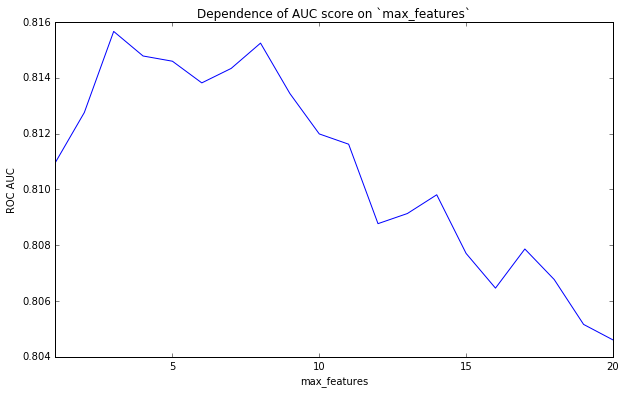

In [188]:
for label, x in auc_scores.items():
    xs, ys = zip(*x)
    plt.plot(xs, ys, label=label)

plt.title("Dependence of AUC score on `max_features`")
plt.xlim(min_par, max_par)
plt.xlabel("max_features")
plt.ylabel("ROC AUC")

plt.show()

In [189]:
# Select the model with the highest score

# Get the curve with the best roc auc score
g = lambda x: x[1]
f = lambda y: max( y[1], key = g)
best_model = max(list(auc_scores.items()), key = f)

# Get the best score for the model
best_score = max(best_model[1], key = g)

print("n_featres=", 150)
print("Best (<max_features>, <roc auc>):", best_score)

n_featres= 150
Best (<max_features>, <roc auc>): (3, 0.81566583751660404)


Perhaps surprisingly, the ROC AUC score favors a relatively small value for `max_features`.